<a href="https://colab.research.google.com/github/surajK610/AI/blob/master/Book_Classification_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import os
import networkx as nx

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import entropy

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings

from itertools import chain

style.use('ggplot')
warnings.filterwarnings(action='ignore')

In [2]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/My Drive/'

node_path = os.path.join(gdrive_path, 'anon_nodes_2k.csv')
edge_path = os.path.join(gdrive_path, 'anon_edges_2k.csv')

Mounted at /content/gdrive


In [3]:
nodes = pd.read_csv(node_path)
edges = pd.read_csv(edge_path)

# **Exploratory Data Analysis**

### Graph Visualization

In [4]:
def create_graph(edges):
  G = nx.from_pandas_edgelist(edges, 'Book', 'Customer')
  return G

def plot_graph(edges, nodes):
  G = create_graph(edges)
  pos = nx.spring_layout(G)

  classes = nodes.Category.unique()
  colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#aec7e8', '#ffbb78']
  class_color = dict(zip(classes, colors))

  shape_symbol = {False: 'circle', True: 'cross'}

  node_x = []
  node_y = []
  node_color, node_shape = [], []
  for node in G.nodes():
      x, y = pos[node]
      node_x.append(x)
      node_y.append(y)
      if node in nodes['ID'].tolist():
        category = (nodes[nodes['ID'] == node].iloc[0].Category)
        fake = (nodes[nodes['ID'] == node].iloc[0].isFake)
        node_color.append(class_color[category])
        node_shape.append(shape_symbol[fake])
      else:
        node_color.append('black')
        node_shape.append('square')

  edge_x = []
  edge_y = []
  for edge in G.edges():
      x0, y0 = pos[edge[0]]
      x1, y1 = pos[edge[1]]
      edge_x.append(x0)
      edge_x.append(x1)
      edge_y.append(y0)
      edge_y.append(y1)

  edge_trace = go.Scatter(
      x=edge_x, y=edge_y,
      line=dict(width=0.5, color='#888'),
      hoverinfo='none',
      mode='lines')

  node_trace = go.Scatter(
      x=node_x, y=node_y,
      mode='markers',
      hoverinfo='text',
      marker=dict(
        showscale=True,
        colorscale='Viridis',
        size=10,
        color=node_color,
        symbol=node_shape,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right')
    )
  )

  node_trace['text'] = ()
  for node in G.nodes():
      x, y = pos[node]
      if node in nodes['ID'].tolist():
        category = (nodes[nodes['ID'] == node].iloc[0].Category)
        fake =  'Fake' if (nodes[nodes['ID'] == node].iloc[0].isFake) else 'Real'
        node_trace['text'] += (f'Cat {category}, {fake}',)
      else:
        node_trace['text'] += ('Unknown',)

  fig = go.Figure(data=[edge_trace, node_trace],
              layout=go.Layout(
                  showlegend=False,
                  hovermode='closest',
                  margin=dict(b=0,l=0,r=0,t=0),
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                  )
  fig.show()
  return G, fig

In [5]:
G, fig = plot_graph(edges, nodes)

**Observations**
1. Looks like similar groups are located close to each other in the graph.
(can do some basic clustering to get a naive baseline to describe the data)

2. Looks like fake customers have a far more random distribution, and thus are connected to far more types of groups (can use some sort of distribution statistical analysis to filter potentially)

3. Different distribution of values


### Distribution Statistics

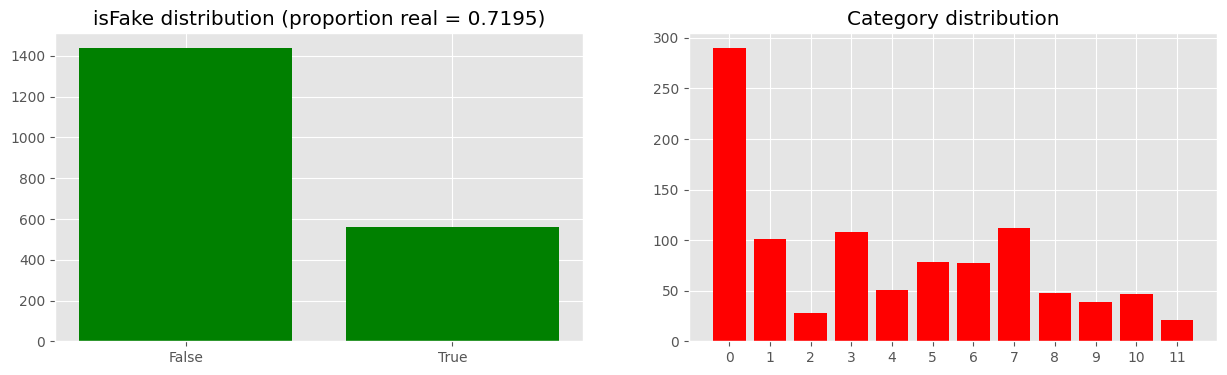

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

## isFake distribution
bar_counts = nodes['isFake'].value_counts()
ax1.bar([str(val) for val in bar_counts.index], bar_counts, color='g')
_ = ax1.set_title(f'isFake distribution (proportion real = {bar_counts.loc[False]/bar_counts.sum()})')

## Category distribution
bar_counts = nodes['Category'].value_counts().drop(-1)
bar_counts = bar_counts.sort_index()
ax2.bar([str(val) for val in bar_counts.index], bar_counts, color='r')
_ = ax2.set_title(f'Category distribution')

In [7]:
def plot_customer(cust_id):
  booklist_cust = edges[edges['Customer'] == cust_id]
  booklist_cust = nodes[nodes['ID'].isin(booklist_cust['Book'])]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2))

  fake_counts = booklist_cust['isFake'].value_counts()
  fake_counts_index = ['Fake' if val else 'Real' for val in fake_counts.index]
  ax1.bar(fake_counts_index, fake_counts, color='g')
  ax1.set_title(f'book neighbor distribution (proportion real = {fake_counts.loc[False]/fake_counts.sum():.2f})')

  cat_counts = booklist_cust['Category'].value_counts()
  cat_counts = cat_counts.sort_index()
  ax2.bar([str(val) for val in cat_counts.index], cat_counts, color='r')
  ax2.set_title(f'Category distribution')

  return ax1, ax2


### Fake Customer Distributions

In [8]:
nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == True)].sample(3)

,ID,Type,isFake,Category
623,100623,Customer,True,-1
1528,101528,Customer,True,-1
609,100609,Customer,True,-1


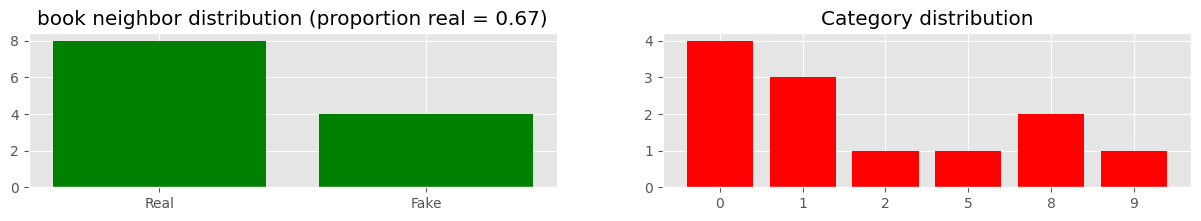

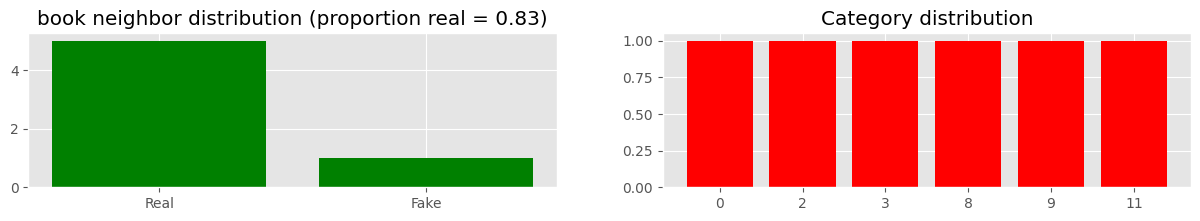

In [9]:
## Fake Customer Examples [ID = 100030]
_, _ = plot_customer(100030)

## FakeCustomer Examples [ID = 101138]
_, _ = plot_customer(101138)

# ## Fake Customer Examples [ID = 101682]
# _, _ = plot_customer(101682)


### Real Customer Distributions

In [10]:
nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == False)].sample(3)

,ID,Type,isFake,Category
110,100110,Customer,False,-1
1317,101317,Customer,False,-1
1333,101333,Customer,False,-1


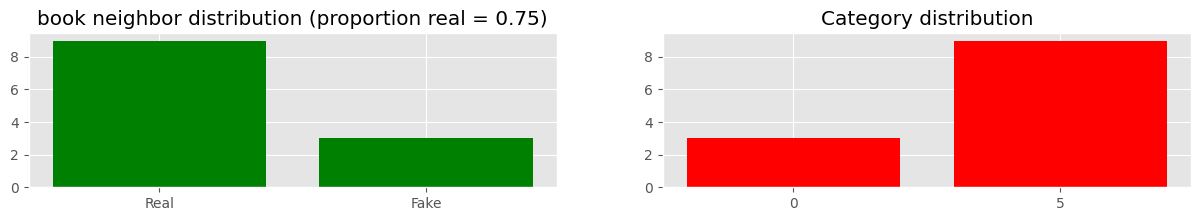

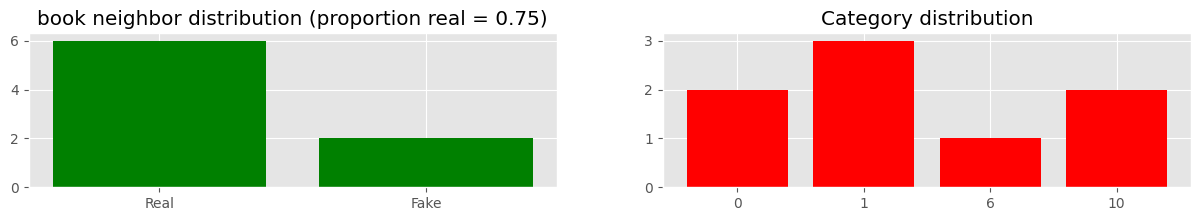

In [11]:
## Real Customer Examples [ID = 101264]
_, _ = plot_customer(101264)

## Real Customer Examples [ID = 101545]
_, _ = plot_customer(101545)

# ## Real Customer Examples [ID = 101979]
# _, _ = plot_customer(101979)


### Fake vs. Real Customer Distributional Differences

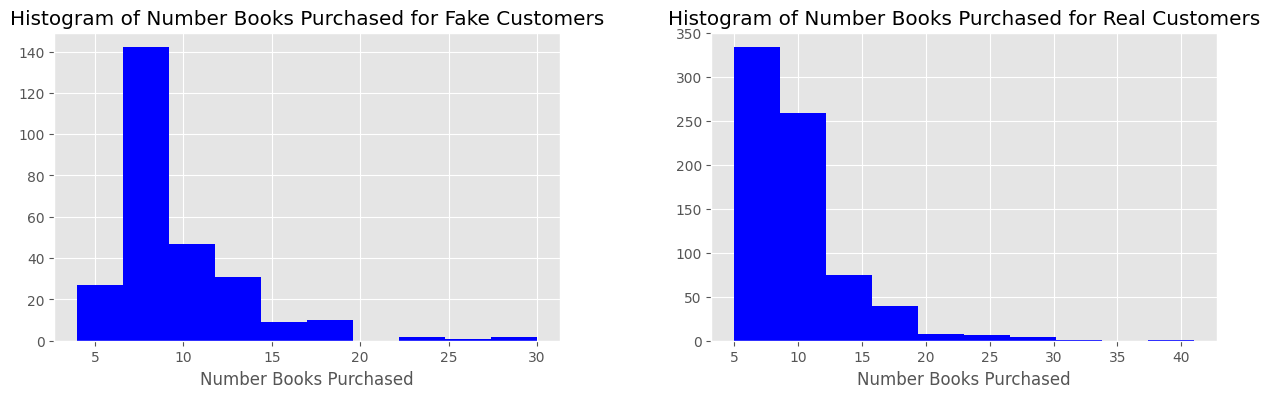

In [12]:
## Avg Number Neighbors Fake vs. Real Customers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

fake_customers = nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == True)]['ID']
edges[edges['Customer'].isin(fake_customers)].groupby('Customer').count().hist(ax=ax1, color='blue')
ax1.set_xlabel('Number Books Purchased')
ax1.set_title('Histogram of Number Books Purchased for Fake Customers')

real_customers = nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == False)]['ID']
edges[edges['Customer'].isin(real_customers)].groupby('Customer').count().hist(ax=ax2, color='blue')
ax2.set_xlabel('Number Books Purchased')
_ = ax2.set_title('Histogram of Number Books Purchased for Real Customers')


In [13]:
def unique_categories(list_books):
  return nodes[nodes['ID'].isin(list_books[0])]['Category'].nunique()

def unique_categories_real(list_books):
  return nodes[(nodes['ID'].isin(list_books[0])) & (nodes['Category']  != 0)]['Category'].nunique()

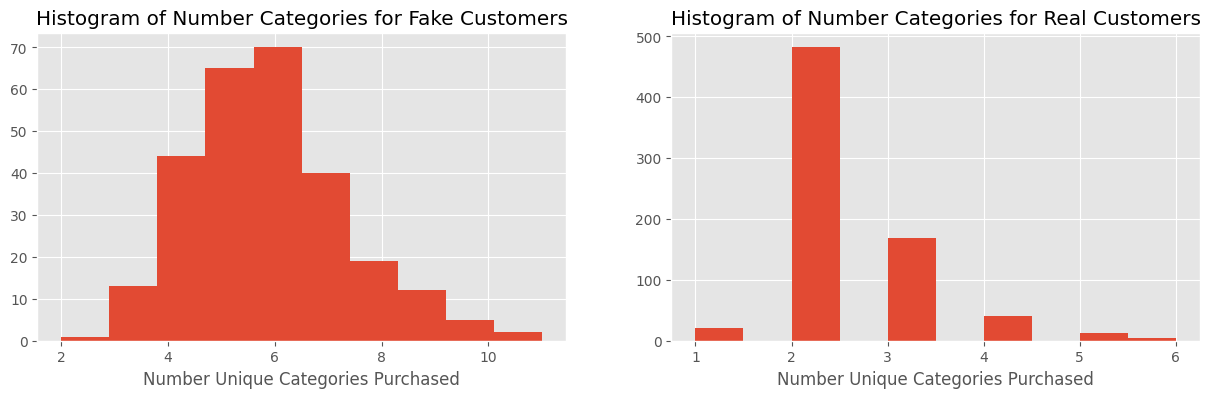

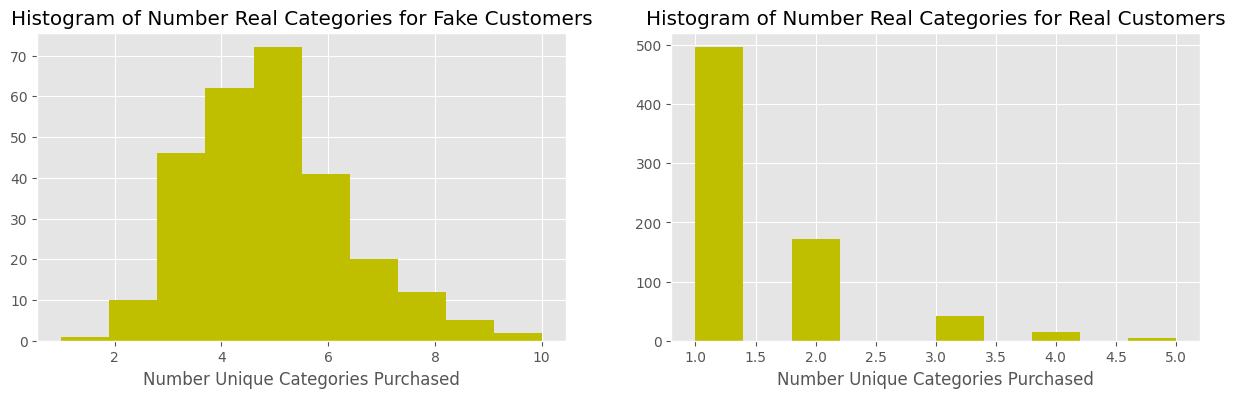

In [14]:
## Avg Number Unique Categories of Neighbors Fake vs. Real Customers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

fake_customers = nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == True)]['ID']
edges[edges['Customer'].isin(fake_customers)].groupby('Customer').agg(list).apply(unique_categories, axis=1).hist(ax=ax1)
ax1.set_xlabel('Number Unique Categories Purchased')
ax1.set_title('Histogram of Number Categories for Fake Customers')

real_customers = nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == False)]['ID']
edges[edges['Customer'].isin(real_customers)].groupby('Customer').agg(list).apply(unique_categories, axis=1).hist(ax=ax2)
ax2.set_xlabel('Number Unique Categories Purchased')
_ = ax2.set_title('Histogram of Number Categories for Real Customers')

## Avg Number Unique Categories of Neighbors Fake vs. Real Customers (Without Fake Books)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

fake_customers = nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == True)]['ID']
edges[edges['Customer'].isin(fake_customers)].groupby('Customer').agg(list).apply(unique_categories_real, axis=1).hist(ax=ax1, color='y')
ax1.set_xlabel('Number Unique Categories Purchased')
ax1.set_title('Histogram of Number Real Categories for Fake Customers')

real_customers = nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == False)]['ID']
edges[edges['Customer'].isin(real_customers)].groupby('Customer').agg(list).apply(unique_categories_real, axis=1).hist(ax=ax2, color='y')
ax2.set_xlabel('Number Unique Categories Purchased')
_ = ax2.set_title('Histogram of Number Real Categories for Real Customers')


**Observations**
* Fake Customers have far more categories of books that they purchase on average
* Real Customers have very few unique categories of books that they normally purchase

### Fake vs. Real Book Distributional Differences

In [15]:
def customers_real(list_customers):
  return nodes[(nodes['ID'].isin(list_customers[0])) & (nodes['isFake']  == False)]['Category'].count()

def customers_fake(list_customers):
  return nodes[(nodes['ID'].isin(list_customers[0])) & (nodes['isFake']  == True)]['Category'].count()

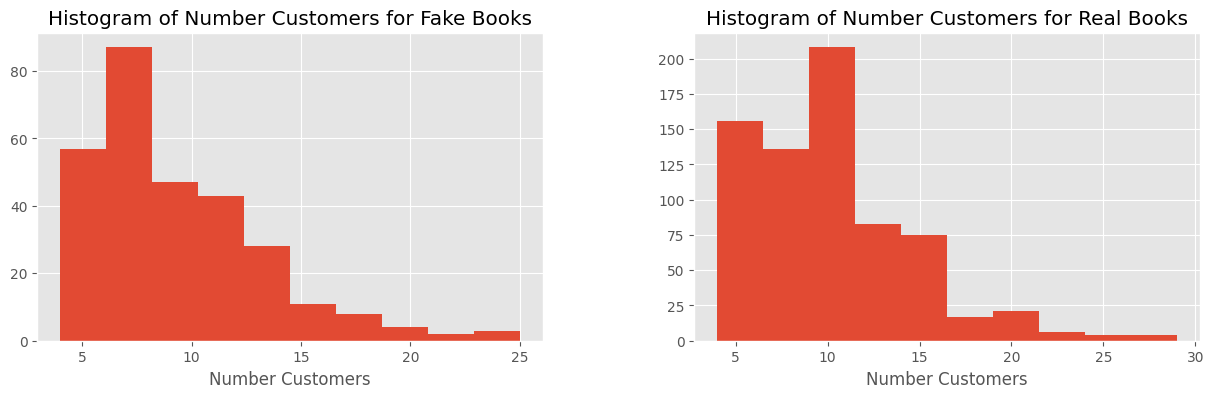

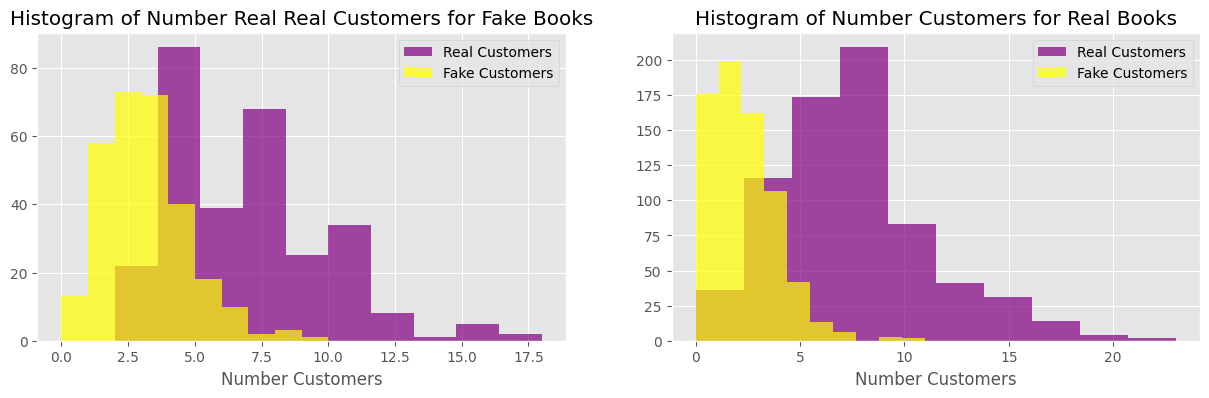

In [16]:
## Avg Number of Customers Fake vs. Real Books
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

fake_books = nodes[(nodes['Type'] == 'Book') & (nodes['isFake'] == True)]['ID']
edges[edges['Book'].isin(fake_books)].groupby('Book').count().hist(ax=ax1)
ax1.set_xlabel('Number Customers')
ax1.set_title('Histogram of Number Customers for Fake Books')

real_books = nodes[(nodes['Type'] == 'Book') & (nodes['isFake'] == False)]['ID']
edges[edges['Book'].isin(real_books)].groupby('Book').count().hist(ax=ax2)
ax2.set_xlabel('Number Customers')
ax2.set_title('Histogram of Number Customers for Real Books')

## Avg Number of Customers Fake vs. Real Books  (Without Fake Customers)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

fake_books = nodes[(nodes['Type'] == 'Book') & (nodes['isFake'] == True)]['ID']
edges[edges['Book'].isin(fake_books)].groupby('Book').agg(list).apply(customers_real, axis=1).hist(ax=ax1, alpha=0.7, color='purple', label='Real Customers')
edges[edges['Book'].isin(fake_books)].groupby('Book').agg(list).apply(customers_fake, axis=1).hist(ax=ax1, alpha=0.7, color='yellow', label='Fake Customers')
ax1.legend()
ax1.set_xlabel('Number Customers')
ax1.set_title('Histogram of Number Real Real Customers for Fake Books')

real_books = nodes[(nodes['Type'] == 'Book') & (nodes['isFake'] == False)]['ID']
edges[edges['Book'].isin(real_books)].groupby('Book').agg(list).apply(customers_real, axis=1).hist(ax=ax2, alpha=0.7, color='purple', label='Real Customers')
edges[edges['Book'].isin(real_books)].groupby('Book').agg(list).apply(customers_fake, axis=1).hist(ax=ax2, alpha=0.7, color='yellow', label='Fake Customers')
ax2.legend()
ax2.set_xlabel('Number Customers')
_ = ax2.set_title('Histogram of Number Customers for Real Books')


**Observations**
* Looks like it might be difficult to find a clear signal in these graphs
* Seems that there are fewer real customers for fake books than real books, but this is a noisy signal that could not give us a clear way to differentiate


### Fake vs. Real Book Customer Purchasing Differences

In [17]:
def plot_book_customer(book_id, filter=False, figsize=(15, 4)):
  booklist_cust = edges[edges['Book'] == book_id]['Customer'].tolist()
  if filter:
    booklist_cust = nodes[(nodes['ID'].isin(booklist_cust)) & (nodes['isFake'] == False)]['ID'].tolist()
    ## filters fake customers
  booklist_cust = edges[edges['Customer'].isin(booklist_cust)]['Book'].tolist()
  otherbooks = nodes[nodes['ID'].isin(booklist_cust)]['Category'].value_counts()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
  fake_counts = otherbooks[0] if 0 in otherbooks.index else 0
  fake_counts = (fake_counts, otherbooks.sum() - fake_counts)
  fake_counts_index = ('Fake', 'Real')
  ax1.bar(fake_counts_index, fake_counts, color='g')
  ax1.set_title(f'Other Bought Books Distribution (proportion real = {fake_counts[1]/otherbooks.sum():.2f})')

  otherbooks = otherbooks.sort_index()
  ax2.bar([str(val) for val in otherbooks.index], otherbooks, color='r')
  ax2.set_title(f'Other Bought Books Category Distribution')

  return ax1, ax2



In [18]:
nodes[(nodes['Type'] == 'Book') & (nodes['isFake'] == True)].sample(3)

,ID,Type,isFake,Category
504,100504,Book,True,0
1227,101227,Book,True,0
174,100174,Book,True,0


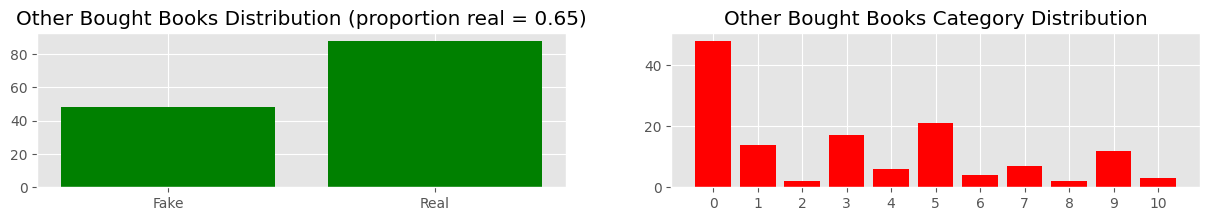

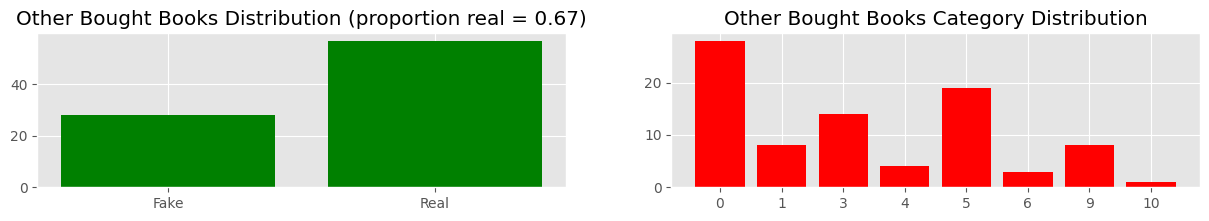

In [19]:
## Fake Book Examples [ID = 101278]
_, _ = plot_book_customer(101427, figsize=(15, 2))
_, _ = plot_book_customer(101427, filter=True, figsize=(15, 2))

# ## Fake Book Examples [ID = 100815]
# _, _ = plot_book_customer(100815, figsize=(15, 2))
# _, _ = plot_book_customer(100815, filter=True, figsize=(15, 2))

# ## Fake Book Examples [ID = 100983]
# _, _ = plot_book_customer(100983)
# _, _ = plot_book_customer(100983, filter=True, figsize=(15, 2))

In [20]:
nodes[(nodes['Type'] == 'Book') & (nodes['isFake'] == False)].sample(3)

,ID,Type,isFake,Category
1484,11484,Book,False,3
978,10978,Book,False,5
368,10368,Book,False,11


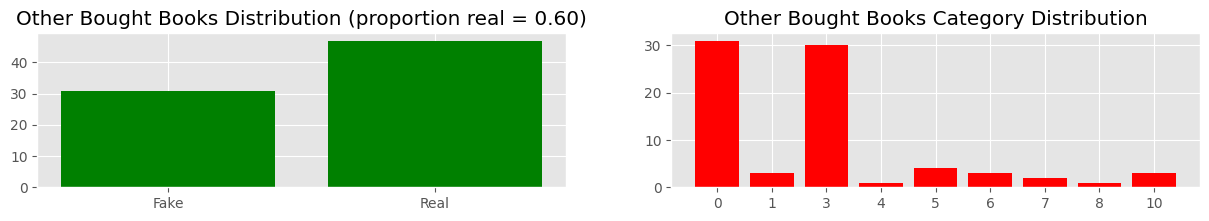

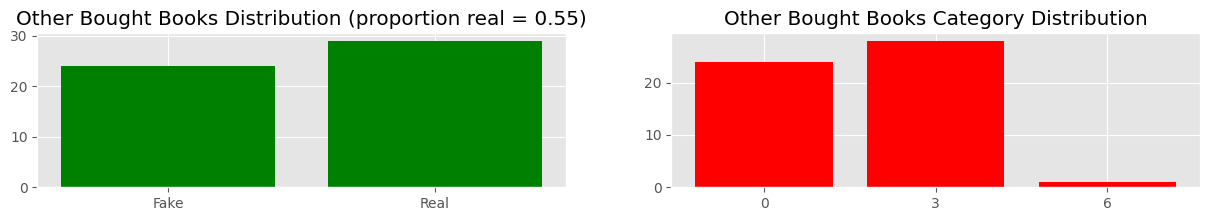

In [21]:
## Real Book Examples [ID = 11115]
_, _ = plot_book_customer(11115, figsize=(15, 2))
_, _ = plot_book_customer(11115, filter=True, figsize=(15, 2))

# ## Real Book Examples [ID = 10536]
# _, _ = plot_book_customer(10536, figsize=(15, 2))
# _, _ = plot_book_customer(10536, filter=True, figsize=(15, 2))

# ## Real Book Examples [ID = 11149]
# _, _ = plot_book_customer(11149)
# _, _ = plot_book_customer(11149, filter=True, figsize=(15, 2))



**Observations**

* Looks like we can clearly differentiate between real and fake books by distributional differences (fake books have much higher entropy for other bought books by a customer)
* Once we filter out fake customers, this difference becomes even more obvious

# **Solution Development**

## Train Test Split

* Split the data into train and test as a 30-70 split
* Assume per instructions that we know all the edges
* For test set, we do not know the status of the nodes

**Information we Know** \\
*Customer Train*: Know Books Purchased & isFake \\
*Books Train*: Know Category & isFake (Know Customers Purchased) \\
*Customer Test*: Know Books Purchased \\
*Books Test*: (Know Customers Purchased)

In [22]:
TRAIN_FRAC = 0.30

customers_train, books_train = nodes[nodes['Type'] == 'Customer'].sample(frac=0.30, random_state=42), nodes[nodes['Type'] == 'Book'].sample(frac=0.30, random_state=42)
customers_test, books_test = nodes[nodes['Type'] == 'Customer'].drop(customers_train.index), nodes[nodes['Type'] == 'Book'].drop(books_train.index)

In [23]:
G, fig = plot_graph(edges, pd.concat([books_train, customers_train], axis=0))

## Models

### **Strategy 1**
1. Given a particular book, filter customers who have bought this book
2. Calculate the highest proportion known train category book bought from each of these customers - each customer will be represented by this category
3. Each customer has one vote, and the winner of the vote wins

In [24]:
def get_maj_booktype(cust_id):
  booklist_cust = edges[(edges['Customer'] == cust_id) & (edges['Book'].isin(books_train['ID'].tolist()))]
  ## only know book labels in train set

  booklist_cust = nodes[nodes['ID'].isin(booklist_cust['Book'])]
  if len(booklist_cust['Category']) == 0:
    return np.nan
    ## returns np.nan if no books in train set
  return booklist_cust['Category'].value_counts().index[0]

In [25]:
customers_per_test_book = edges[(edges['Book'].isin(books_test['ID'].tolist()))]
customers_per_test_book['Maj_Category'] = customers_per_test_book['Customer'].apply(get_maj_booktype)

In [26]:
predictions = customers_per_test_book[['Book', 'Maj_Category']].groupby('Book').agg(pd.Series.mode)
predictions = predictions.reset_index()
predictions = predictions.merge(books_test[['ID', 'Category']], left_on='Book', right_on='ID', how='inner')

In [27]:
pred_corr = lambda row: any(row['Maj_Category'] in row['Category']) if type(row['Category']) == np.ndarray else (row['Maj_Category'] == row['Category'])
predictions['Correct'] = predictions.apply(pred_corr, axis=1)
predictions['Correct'] = predictions['Correct'].apply(lambda x: any(x) if type(x) == np.ndarray else x)

In [28]:
upp_bound_acc = predictions['Correct'].mean()
upp_bound_acc_no_fake = predictions.loc[predictions['Category'] != 0, 'Correct'].mean()
print("Upper bound accuracy", upp_bound_acc)
print("Upper bound accuracy (excluding fake category)", upp_bound_acc_no_fake)

Upper bound accuracy 0.7128571428571429
Upper bound accuracy (excluding fake category) 0.757085020242915


In [29]:
prop_tied = predictions['Maj_Category'].apply(lambda x: type(x) == np.ndarray).mean()
prop_tied_no_fake = predictions.loc[predictions['Category'] != 0, 'Maj_Category'].apply(lambda x: type(x) == np.ndarray).mean()

print("Proportion with ties", prop_tied)
print("Proportion with ties (excluding fake category)", prop_tied_no_fake)

Proportion with ties 0.21
Proportion with ties (excluding fake category) 0.14777327935222673


In [30]:
low_bound_acc = upp_bound_acc - prop_tied
low_bound_acc_no_fake = upp_bound_acc_no_fake - prop_tied_no_fake

print(f"Accuracy range [{low_bound_acc}, {upp_bound_acc}]")
print(f"Accuracy range (excluding fake category) [{low_bound_acc_no_fake}, {upp_bound_acc_no_fake}]")

Accuracy range [0.5028571428571429, 0.7128571428571429]
Accuracy range (excluding fake category) [0.6093117408906883, 0.757085020242915]


### **Strategy 2**

It looks like Strategy 1's Accuracy Range is a bit large and low - let's try and include less ties with a better strategy.

1. Given a particular book, filter customers who have bought this book in train set
2. Calculate the distribution of train books bought from each of these customers - each customer will be represented by this distribution
3. Compute an average distribution where each customer is weighted evenly
4. Choose the book category with the most mass allocated to it

In [31]:
def get_dist_booktype(cust_id_list, norm=True):
  dist = []
  for cust_id in cust_id_list[0]:

    booklist_cust = edges[(edges['Customer'] == cust_id) & (edges['Book'].isin(books_train['ID'].tolist()))]
    ## only can use books in train set
    if (len(booklist_cust) == 0):
      continue
    booklist_cust = nodes[nodes['ID'].isin(booklist_cust['Book'])]
    if norm:
      dist.append(booklist_cust['Category'].value_counts()/len(booklist_cust['Category']))
    else:
      dist.append(booklist_cust['Category'].value_counts())

  all_dists = pd.concat(dist, axis=1)
  all_dists = all_dists.sum(axis=1)/all_dists.shape[1]
  return (tuple(all_dists.loc[all_dists == all_dists.max()].index), all_dists.max())

In [32]:
customers_per_test_book = edges[(edges['Book'].isin(books_test['ID'].tolist()))]
customers_per_test_book = customers_per_test_book.groupby('Book').agg(list)
customers_per_test_book['Max_Dist_Category'] = customers_per_test_book.apply(
    lambda x: get_dist_booktype(x, norm=True), axis=1)

In [33]:
customers_per_test_book['Pred_Category'] = customers_per_test_book['Max_Dist_Category'].apply(lambda x: x[0])
predictions = customers_per_test_book.merge(books_test[['ID', 'Category']], left_on='Book', right_on='ID', how='inner')

In [34]:
pred_corr = lambda row: (row['Category'] in row['Pred_Category'])
predictions['Correct'] = predictions.apply(pred_corr, axis=1)

In [35]:
upp_bound_acc = predictions['Correct'].mean()
upp_bound_acc_no_fake = predictions.loc[predictions['Category'] != 0, 'Correct'].mean()
print("Upper Bound Accuracy", upp_bound_acc)
print("Upper Bound Accuracy (excluding fake category)", upp_bound_acc_no_fake)

Upper Bound Accuracy 0.6971428571428572
Upper Bound Accuracy (excluding fake category) 0.7024291497975709


In [36]:
prop_tied = predictions['Max_Dist_Category'].apply(lambda x: len(x[0]) > 1).mean()
prop_tied_no_fake = predictions.loc[predictions['Category'] != 0, 'Max_Dist_Category'].apply(lambda x: len(x[0]) > 1).mean()

print("Proportion with ties", prop_tied)
print("Proportion with ties (excluding fake category)", prop_tied_no_fake)

Proportion with ties 0.015714285714285715
Proportion with ties (excluding fake category) 0.01417004048582996


In [37]:
low_bound_acc = upp_bound_acc - prop_tied
low_bound_acc_no_fake = upp_bound_acc_no_fake - prop_tied_no_fake

print(f"Accuracy range [{low_bound_acc}, {upp_bound_acc}]")
print(f"Accuracy range (excluding fake category) [{low_bound_acc_no_fake}, {upp_bound_acc_no_fake}]")

Accuracy range [0.6814285714285715, 0.6971428571428572]
Accuracy range (excluding fake category) [0.688259109311741, 0.7024291497975709]


In [38]:
print(classification_report(predictions['Category'], predictions['Pred_Category'].apply(lambda x: x[0])))
## classification for random state

              precision    recall  f1-score   support

           0       0.54      0.68      0.60       206
           1       0.72      0.76      0.74        68
           2       1.00      0.53      0.69        19
           3       0.79      0.92      0.85        76
           4       0.84      0.68      0.75        38
           5       0.74      0.49      0.59        53
           6       0.77      0.66      0.71        56
           7       0.77      0.94      0.85        72
           8       1.00      0.62      0.76        34
           9       0.73      0.24      0.36        33
          10       0.61      0.47      0.53        30
          11       0.85      0.73      0.79        15

    accuracy                           0.69       700
   macro avg       0.78      0.64      0.69       700
weighted avg       0.71      0.69      0.68       700



### **Strategy 3**

Up to this point, we implicitly determine fake vs. real books. We have not used any of our exploratory analysis about fake vs. real distributional differences. We can try to incorporate that information into the model to improve our predictive power further (and improve precision for this category).

Specifically, we first know that fake customers have a distribution that is far more entropic than real customers -> let's see whether we can classify fake customers based off of this and use that to determine real vs. fake books better

Then, we can not include fake customers in the classification and classify fake vs. real books based on clear distributional differences

In [39]:
def get_dist(book_categories):
  dist = np.zeros(12,)
  dist_value_counts = book_categories.value_counts()/len(book_categories)
  for i in dist_value_counts.index:
    dist[i] = dist_value_counts[i]
  return tuple(dist)

In [40]:
## gets connected books in train to analyze stats
purchases_customers = edges[(edges['Book'].isin(books_train['ID'].tolist()))]
purchases_customers['Book_Category'] = purchases_customers['Book'].apply(lambda x: nodes[nodes['ID'] == x]['Category'].iloc[0])
purchases_customers = purchases_customers.drop('Book', axis=1).groupby('Customer').agg([get_dist, 'count'])
purchases_customers.columns = ['Book_Category', 'Count']

## creates entropy and num_nonzero features
purchases_customers['Entropy'] = purchases_customers['Book_Category'].apply(entropy)
purchases_customers['Num_Nonzero'] = purchases_customers['Book_Category'].apply(np.count_nonzero)
purchases_customers = purchases_customers.reset_index().merge(nodes[['ID', 'isFake']], left_on='Customer', right_on='ID', how='inner').drop('ID', axis=1)
purchases_c_train = purchases_customers[purchases_customers['Customer'].isin(customers_train['ID'].tolist())]
purchases_c_test = purchases_customers[purchases_customers['Customer'].isin(customers_test['ID'].tolist())]

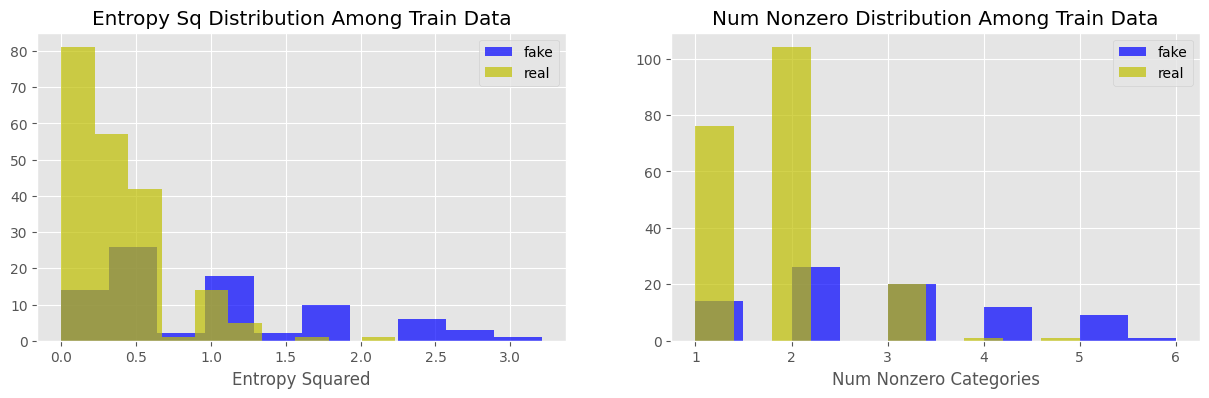

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

(purchases_c_train[purchases_c_train['isFake'] == True]['Entropy']**2).hist(ax=ax1, alpha=0.7, color='b', label='fake')
(purchases_c_train[purchases_c_train['isFake'] == False]['Entropy']**2).hist(ax=ax1, alpha=0.7, color='y', label='real')
ax1.legend()
ax1.set_xlabel('Entropy Squared')
ax1.set_title('Entropy Sq Distribution Among Train Data')

purchases_c_train[purchases_c_train['isFake'] == True]['Num_Nonzero'].hist(ax=ax2, alpha=0.7, color='b', label='fake')
purchases_c_train[purchases_c_train['isFake'] == False]['Num_Nonzero'].hist(ax=ax2, alpha=0.7, color='y', label='real')
ax2.set_xlabel('Num Nonzero Categories')
ax2.legend()
_ = ax2.set_title('Num Nonzero Distribution Among Train Data')

Based off of our training data, we can threshold customers that have an Entropy squared greater than 0.6 or a number of nonzero categories greater than 2 to capture a good chunk of the fake data (this captures some of the real data, but the part it captures is the messier data anyway).

In [42]:
purchases_c_all = pd.concat([purchases_c_train, purchases_c_test])
purchases_c_all['Weight'] = 1 - (((purchases_c_all['Entropy']**2) > 1) | (purchases_c_all['Num_Nonzero'] > 3)).astype(int)
purchases_c_all.index = purchases_c_all['Customer']


In [43]:
purchases_c_all

,Customer,Book_Category,Count,Entropy,Num_Nonzero,isFake,Weight
Customer,,,,,,,
100007,100007,"(0.16666666666666666, 0.0, 0.16666666666666666...",6,1.560710,5,True,0
100008,100008,"(0.5, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,0.693147,2,False,1
100015,100015,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.000000,1,False,1
100018,100018,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.000000,1,False,1
100021,100021,"(0.25, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0...",4,0.562335,2,False,1
...,...,...,...,...,...,...,...
101986,101986,"(0.6666666666666666, 0.0, 0.0, 0.3333333333333...",3,0.636514,2,False,1
101987,101987,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.000000,1,False,1
101993,101993,"(0.5, 0.375, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",8,0.974315,3,False,1


In [105]:
def weighted_dist(cust_list):
  weights = []
  for cust in cust_list[0]:
    if cust not in purchases_c_all.index:
      continue
    cust_info = purchases_c_all.loc[cust]
    if cust_info['Weight'] == 0:
      continue
    weights.append(np.array(cust_info['Book_Category']))
  dist_final = np.sum(weights, axis=0)/len(weights)

  return (tuple([i for i in range(len(dist_final)) if dist_final[i] == dist_final.max()]), dist_final.max())

In [106]:
customers_per_test_book = edges[(edges['Book'].isin(books_test['ID'].tolist()))]
customers_per_test_book = customers_per_test_book.groupby('Book').agg(list)
customers_per_test_book['Max_Dist_Category'] = customers_per_test_book.apply(weighted_dist, axis=1)
customers_per_test_book['Pred_Category'] = customers_per_test_book['Max_Dist_Category'].apply(lambda x: x[0])
customers_per_test_book = customers_per_test_book.reset_index()

In [107]:
def get_total_neighbors(cust_list):
  neighbors = 0
  for cust in cust_list:
    if cust in purchases_c_all.index:
      neighbors += purchases_c_all.loc[cust, 'Count']
  return neighbors

In [108]:
predictions = customers_per_test_book.merge(books_test[['ID', 'Category']], left_on='Book', right_on='ID', how='inner')
predictions['Num_Customers'] = predictions['Customer'].apply(lambda x: len(x))
predictions['Num_Neighbors'] = predictions['Customer'].apply(lambda x: get_total_neighbors(x))
pred_corr = lambda row: (row['Category'] in row['Pred_Category'])
predictions['Correct'] = predictions.apply(pred_corr, axis=1)

<Axes: >

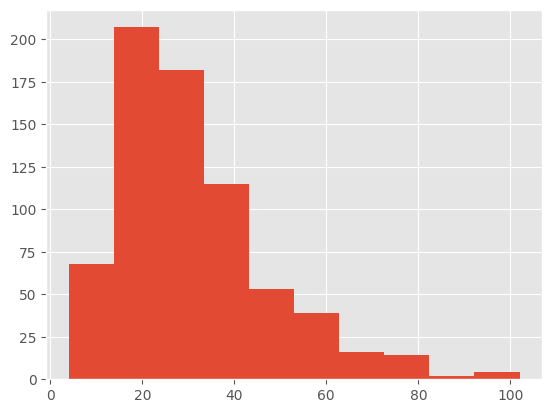

In [109]:
predictions['Num_Neighbors'].hist()

In [110]:
predictions.loc[(predictions['Num_Neighbors'] >= 50), 'Correct'].mean()

0.872093023255814

In [111]:
upp_bound_acc = predictions['Correct'].mean()
upp_bound_acc_no_fake = predictions.loc[predictions['Category'] != 0, 'Correct'].mean()
print("Upper Bound Accuracy", upp_bound_acc)
print("Upper Bound Accuracy (excluding fake category)", upp_bound_acc_no_fake)

Upper Bound Accuracy 0.6985714285714286
Upper Bound Accuracy (excluding fake category) 0.7327935222672065


In [112]:
prop_tied = predictions['Max_Dist_Category'].apply(lambda x: len(x[0]) > 1).mean()
prop_tied_no_fake = predictions.loc[predictions['Category'] != 0, 'Max_Dist_Category'].apply(lambda x: len(x[0]) > 1).mean()

print("Proportion with ties", prop_tied)
print("Proportion with ties (excluding fake category)", prop_tied_no_fake)

Proportion with ties 0.04
Proportion with ties (excluding fake category) 0.038461538461538464


In [113]:
low_bound_acc = upp_bound_acc - prop_tied
low_bound_acc_no_fake = upp_bound_acc_no_fake - prop_tied_no_fake

print(f"Accuracy range [{low_bound_acc}, {upp_bound_acc}]")
print(f"Accuracy range (excluding fake category) [{low_bound_acc_no_fake}, {upp_bound_acc_no_fake}]")

Accuracy range [0.6585714285714286, 0.6985714285714286]
Accuracy range (excluding fake category) [0.6943319838056681, 0.7327935222672065]


### **Strategy 4**

It looks like this tail-clipping improves the accuracy slightly. Let's try an iterative optimization approach that works from our previous solution here that now uses the labels we computed as pseudo-labels and tries to recompute the graph.

In [54]:
purchases_customers

,Customer,Book_Category,Count,Entropy,Num_Nonzero,isFake
0,100000,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.000000,1,True
1,100003,"(0.25, 0.0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0...",4,1.039721,3,False
2,100007,"(0.16666666666666666, 0.0, 0.16666666666666666...",6,1.560710,5,True
3,100008,"(0.5, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,0.693147,2,False
4,100010,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.000000,1,True
...,...,...,...,...,...,...
946,101992,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.000000,1,False
947,101993,"(0.5, 0.375, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",8,0.974315,3,False
948,101994,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, ...",2,0.693147,2,True
949,101995,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2,0.000000,1,False


In [59]:
purchases_customers = edges[(edges['Book'].isin(books_train['ID'].tolist()))]


In [60]:
purchases_customers

,Book,Customer,Book_Category
5,10162,100850,7
7,10172,101669,3
8,11706,100516,5
9,100472,100574,0
11,11921,100904,10
...,...,...,...
9860,10612,101545,1
9862,10612,101257,1
9865,11055,100753,7
9870,100983,101644,0


In [103]:
def create_dict_lookup(new_nodes, book_list):
  ## gets connected books in train to analyze stats
  purchases_customers = edges[edges['Book'].isin(book_list)]
  purchases_customers['Book_Category'] = purchases_customers['Book'].apply(lambda x: new_nodes[new_nodes['ID'] == x]['Category'].iloc[0])
  purchases_customers = purchases_customers.drop('Book', axis=1).groupby('Customer').agg([get_dist, 'count'])
  purchases_customers.columns = ['Book_Category', 'Count']

  ## creates entropy and num_nonzero features
  purchases_customers['Entropy'] = purchases_customers['Book_Category'].apply(entropy)
  purchases_customers['Num_Nonzero'] = purchases_customers['Book_Category'].apply(np.count_nonzero)
  purchases_customers = purchases_customers.reset_index().merge(nodes[['ID', 'isFake']], left_on='Customer', right_on='ID', how='inner').drop('ID', axis=1)
  purchases_customers['Weight'] = 1 - (((purchases_customers['Entropy']**2) > 1) | (purchases_customers['Num_Nonzero'] > 3)).astype(int)
  purchases_customers.index = purchases_customers['Customer']
  return purchases_customers


def get_total_neighbors(cust_list, purchases_customers):
  neighbors = 0
  for cust in cust_list:
    if cust in purchases_customers.index:
      neighbors += purchases_customers.loc[cust, 'Count']
  return neighbors

def weighted_dist(cust_list, purchases_customers):
  weights = []
  if isinstance(cust_list[0], list):
    cust_list = cust_list[0]

  for cust in cust_list:
    if cust not in purchases_customers.index:
      continue
    cust_info = purchases_customers.loc[cust]

    # if cust_info['Weight'] == 0:
    #   weights.append(np.array(cust_info['Book_Category']) * 0.2)
    #   continue
    weights.append(np.array(cust_info['Book_Category']))
  dist_final = np.sum(weights, axis=0)/len(weights)
  return (tuple([i for i in range(len(dist_final)) if dist_final[i] == dist_final.max()]), dist_final.max())


def perform_iter(purchases_customers):
  customers_per_test_book = edges[(edges['Book'].isin(books_test['ID'].tolist()))]
  customers_per_test_book = customers_per_test_book.groupby('Book').agg(list)
  weighted_dist_func = lambda c_list: weighted_dist(c_list, purchases_customers)

  customers_per_test_book['Max_Dist_Category'] = customers_per_test_book.apply(weighted_dist_func, axis=1)
  customers_per_test_book['Pred_Category'] = customers_per_test_book['Max_Dist_Category'].apply(lambda x: x[0])


  customers_per_test_book = customers_per_test_book.reset_index()
  predictions = customers_per_test_book.merge(books_test[['ID', 'Category']], left_on='Book', right_on='ID', how='inner')

  get_total_neighbors = lambda c_list: get_total_neighbors(c_list, purchases_customers)
  predictions['Num_Neighbors'] = predictions['Customer'].apply(lambda x: get_total_neighbors(x))

  pred_corr = lambda row: (row['Category'] in row['Pred_Category'])
  predictions['Correct'] = predictions.apply(pred_corr, axis=1)

  upp_bound_acc = predictions['Correct'].mean()
  upp_bound_acc_no_fake = predictions.loc[predictions['Category'] != 0, 'Correct'].mean()
  prop_tied = predictions['Max_Dist_Category'].apply(lambda x: len(x[0]) > 1).mean()
  prop_tied_no_fake = predictions.loc[predictions['Category'] != 0, 'Max_Dist_Category'].apply(lambda x: len(x[0]) > 1).mean()
  low_bound_acc = upp_bound_acc - prop_tied
  low_bound_acc_no_fake = upp_bound_acc_no_fake - prop_tied_no_fake
  return predictions, {
      'upp_bound_acc': upp_bound_acc,
      'upp_bound_acc_no_fake': upp_bound_acc_no_fake,
      'prop_tied': prop_tied,
      'prop_tied_no_fake': prop_tied_no_fake,
      'low_bound_acc': low_bound_acc,
      'low_bound_acc_no_fake': low_bound_acc_no_fake
  }

In [58]:
## start with most likely to be correct nodes (highest customer counts)
# n_iters = 5
# for i in range(n_iters):

## gets first prediction

purchases_customers = create_dict_lookup(all_new_nodes)
predictions, dict_results = perform_iter(purchases_customers)
print(dict_results)

{'upp_bound_acc': 0.6957142857142857, 'upp_bound_acc_no_fake': 0.6963562753036437, 'prop_tied': 0.0, 'prop_tied_no_fake': 0.0, 'low_bound_acc': 0.6957142857142857, 'low_bound_acc_no_fake': 0.6963562753036437}


In [80]:
predictions

,Book,Customer,Max_Dist_Category,Pred_Category,ID,Category,Num_Customers,Num_Neighbors,Correct
0,10001,"[100250, 100442, 101840, 101473, 100749, 10198...","((3,), 0.6067460317460317)","(3,)",10001,3,16,68,True
1,10006,"[100483, 101629, 100541, 100849, 101588, 10162...","((0,), 0.7676190476190475)","(0,)",10006,6,9,32,False
2,10011,"[101292, 101420, 100562, 101104, 100336, 10038...","((11,), 0.7083333333333334)","(11,)",10011,11,7,26,True
3,10023,"[100089, 101218, 101853, 101053, 100072, 10000...","((1,), 0.5555555555555556)","(1,)",10023,1,9,44,True
4,10025,"[100675, 100461, 101397, 100488, 101760, 10182...","((7,), 0.6507936507936508)","(7,)",10025,7,14,49,True
...,...,...,...,...,...,...,...,...,...
695,101953,"[100494, 101910, 101325, 100796, 100470, 100995]","((0,), 0.4138888888888889)","(0,)",101953,0,6,17,True
696,101964,"[100218, 100795, 101909, 100487, 101846, 10039...","((0,), 0.5833333333333334)","(0,)",101964,0,12,37,True
697,101970,"[100541, 100467, 100507, 101805, 101979, 10100...","((0,), 0.40625)","(0,)",101970,0,10,27,True
698,101984,"[101963, 101423, 100664, 101995, 101019, 10047...","((7,), 0.21428571428571427)","(7,)",101984,0,7,16,False


In [87]:
pseudo_labeled_books = predictions[predictions['Num_Neighbors'] >= 39]['Book']
test_new_nodes = predictions[['ID', 'Pred_Category']]
test_new_nodes['Pred_Category']  = test_new_nodes['Pred_Category'].apply(lambda x: x[0])
test_new_nodes = test_new_nodes.rename({'Pred_Category': 'Category'}, axis=1)
all_new_nodes = pd.concat([test_new_nodes, books_train[['ID', 'Category']]])

new_train_books = pseudo_labeled_books.tolist() + books_train['ID'].tolist()


In [88]:
purchases_customers = edges[edges['Book'].isin(new_train_books)]
purchases_customers['Book_Category'] = purchases_customers['Book'].apply(lambda x: all_new_nodes[all_new_nodes['ID'] == x]['Category'].iloc[0])
purchases_customers = purchases_customers.drop('Book', axis=1).groupby('Customer').agg([get_dist, 'count'])
purchases_customers.columns = ['Book_Category', 'Count']

## creates entropy and num_nonzero features
purchases_customers['Entropy'] = purchases_customers['Book_Category'].apply(entropy)
purchases_customers['Num_Nonzero'] = purchases_customers['Book_Category'].apply(np.count_nonzero)
purchases_customers = purchases_customers.reset_index().merge(nodes[['ID', 'isFake']], left_on='Customer', right_on='ID', how='inner').drop('ID', axis=1)
purchases_customers['Weight'] = 1 - (((purchases_customers['Entropy']**2) > 1) | (purchases_customers['Num_Nonzero'] > 3)).astype(int)
purchases_customers.index = purchases_customers['Customer']


In [95]:
def get_total_neighbors(cust_list, purchases_customers):
  neighbors = 0
  for cust in cust_list:
    if cust in purchases_customers.index:
      neighbors += purchases_customers.loc[cust, 'Count']
  return neighbors

def weighted_dist(cust_list, purchases_customers):
  weights = []
  if isinstance(cust_list[0], list):
    cust_list = cust_list[0]

  for cust in cust_list:
    if cust not in purchases_customers.index:
      continue
    cust_info = purchases_customers.loc[cust]

    # if cust_info['Weight'] == 0:
    #   weights.append(np.array(cust_info['Book_Category']) * 0.2)
    #   continue
    weights.append(np.array(cust_info['Book_Category']))
  dist_final = np.sum(weights, axis=0)/len(weights)
  return (tuple([i for i in range(len(dist_final)) if dist_final[i] == dist_final.max()]), dist_final.max())

def cust_type_winner(cust_list, purchases_customers):
  weights = []
  if isinstance(cust_list[0], list):
    cust_list = cust_list[0]

  for cust in cust_list:
    if cust not in purchases_customers.index:
      continue
    cust_info = purchases_customers.loc[cust]

    if cust_info['Weight'] == 0:
      weights.append(np.array(cust_info['Book_Category']) * 0.2)
      continue
    weights.append(np.array(cust_info['Book_Category']))
  dist_final = np.sum(weights, axis=0)/len(weights)
  return (tuple([i for i in range(len(dist_final)) if dist_final[i] == dist_final.max()]), dist_final.max())

In [101]:
edges

,Book,Customer,Book_Category
0,10752,101653,7
1,100322,101568,7
2,101723,101799,0
3,101224,101457,3
4,11466,101253,3
...,...,...,...
9876,100481,101270,0
9877,101503,100910,3
9878,10258,100367,0
9879,10525,101621,2


In [96]:
customers_per_test_book = edges[(edges['Book'].isin(books_test['ID'].tolist()))]
customers_per_test_book = customers_per_test_book.groupby('Book').agg(list)
weighted_dist_func = lambda c_list: weighted_dist(c_list, purchases_customers)

customers_per_test_book['Max_Dist_Category'] = customers_per_test_book.apply(weighted_dist_func, axis=1)
customers_per_test_book['Pred_Category'] = customers_per_test_book['Max_Dist_Category'].apply(lambda x: x[0])


customers_per_test_book = customers_per_test_book.reset_index()
predictions = customers_per_test_book.merge(books_test[['ID', 'Category']], left_on='Book', right_on='ID', how='inner')

get_total_neighbors_func = lambda c_list: get_total_neighbors(c_list, purchases_customers)
predictions['Num_Neighbors'] = predictions['Customer'].apply(lambda x: get_total_neighbors_func(x))

pred_corr = lambda row: (row['Category'] in row['Pred_Category'])
predictions['Correct'] = predictions.apply(pred_corr, axis=1)

In [102]:
predictions['Correct'].mean()

0.6471428571428571